In [1]:
import numpy as np
import ToyQ2
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Data/UH_RL_rats.csv');
df = df.drop(df.columns[[range(24)]],axis=1);
from scipy.optimize import minimize

/Users/maylibooyah69/anaconda2/envs/py3/lib/python3.7/site-packages/pandas/core/indexes/base.py:3969: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


# Packaging into respective subjects

In [14]:
subjects = df['subject'].unique();
sub_df={} # a dictionary whose keys is the subject number
for i in subjects:
    sub_df[i]=df[df['subject']==i]

In [15]:
df = pd.read_csv('Data/UH_RL_rats.csv');

# Note on the Data:
# the update rule used for the given data is different than ours
### There are 24 subjects (1 to 24)
### each subject has 5 sessions (['1', '11', '16', '6', 'Best'])
### each the rat chose between ([1., 2.]) which turns out to be (['lean', 'rich']) depending on the experiment and then get a reward ([0., 1.])
### reward is the same as response, action is the same as lever

In [16]:
def get_Logs(sub_df):
    '''Returns a dict of DataFrame indexs as dict[rat number][session name]
    where rat is int from 1 to 24 and session name is 1, 11, 16,6, Best as strings'''
    Logs={}
    for i in sub_df:
        rat=sub_df[i]
        sessions=rat['session'].unique()
        Logs[i]={}
        for j,sesh in enumerate(sessions):
            Logs[i][sesh]={}
            Logs[i][sesh]=rat[rat['session']==sesh]
    return Logs
epoched_df=get_Logs(sub_df)

In [26]:
# epoched_df[1]

# Simulation

In [39]:
class RL_env():
    def __init__(self,epoched_df):
        '''takes in the data of a rat over one single trial'''
        self.epoched_df=epoched_df
        self.Q=epoched_df['Q']
        self.reward=epoched_df['reward']
        self.test_alphaL=epoched_df['alpha_loss'].iloc[0] # stored as scaler
        self.test_alphaG=epoched_df['alpha_gain'].iloc[0]
        self.test_beta=epoched_df['beta'].iloc[0]
        self.PE=epoched_df['PE']
        self.count=0 # counting from 0
    def step(self,action):
        temp=self.reward.iloc[self.count]+0
        self.count+=1
        return temp
    def get_switchid(self):
        pass
    def init_Q(self):
        left=self.epoched_df[self.epoched_df['action']==1]['Q'].iloc[0]
        right=self.epoched_df[self.epoched_df['action']==2]['Q'].iloc[0]
        return np.array([right,left])

class Rat():
    def __init__(self,epoched_df,alphaG=None,alphaL=None,beta=None,gamma=0,init_Q=np.array([-1,-1]),sim=True):
        self.gamma=gamma
        self.df=epoched_df
        self.count=0
        self.PElog=[] # prediction error (Q-R)
        self.PElog.append(0)
        self.choice_Log=[]
        if sim==False:
            self.alphaG=epoched_df['alpha_gain'].iloc[1]
            self.alphaL=epoched_df['alpha_loss'].iloc[1]
            self.beta=epoched_df['beta'].iloc[1]
            self.actions=epoched_df['action']
        else:
            self.alphaG=alphaG
            self.alphaL=alphaL
            self.beta=beta
        if (init_Q==np.array([-1,-1])).all():
            self.Q=np.random.rand(2) # Q[0] represent left
        else:
            self.Q=init_Q
        self.Qlog=self.Q
        self.qlog=[0]
    def get_action(self):
        temp=self.count+0
        self.count+=1
        self.choice_Log.append(self.actions.iloc[temp])
        return self.actions.iloc[temp]
    def get_choice(self):
        self.count+=1
        if np.random.uniform()<1/(1+np.exp(self.Q[0])):
            self.choice_Log.append(1)
            return 1
        else:
            self.choice_Log.append(2)
            return 2
    def update(self,obs): # 1 represent left 
        action_id=int(self.choice_Log[-1]-1)
        if int(obs)==1: # alpha_gain
            self.Q[action_id]=(1-self.alphaG)*self.Q[action_id]+self.alphaG*(obs+self.gamma*np.max(self.Q))
        elif int(obs)==0: # alpha_loss
            self.Q[action_id]=(1-self.alphaL)*self.Q[action_id]+self.alphaL*(obs+self.gamma*np.max(self.Q))
        else:
            print('error')
        self.Qlog=np.vstack((self.Qlog,self.Q))
        self.qlog.append(self.Q[action_id])
        return self.Q[action_id]
    
    
def train_rat(env,rat,it_num,sim=True):
    QLog=rat.Q
    qlog=[0]
    for i in range(it_num):
        if sim:
            action=rat.get_choice()
        else:
            action=rat.get_action()
        obs=env.step(action)
        q=rat.update(obs)
        QLog=np.vstack((QLog,rat.Q))
        qlog.append(q)
    return env,rat



# Simulation Demo

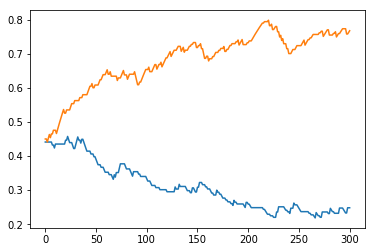

In [31]:
env=ToyQ2.toyQ_2choice()
sim_rat=Rat(None,alphaG=0.02,alphaL=0.02,beta=0.5,init_Q=np.array([0.45,0.45]))
env,sim_rat=train_rat(env,sim_rat,300)
plt.plot(sim_rat.Qlog)

# Real_data Demo

In [42]:
mydf=epoched_df[12]['Best']
env=RL_env(mydf) 
rat=Rat(mydf,init_Q=np.array([0.45,0.45]),sim=False)
env,rat=train_rat(env,rat,mydf.shape[0],sim=False)

# Demo
## the estimation is still off because the initialization value is different and i just put it as the first updated value, but overall it would converge to the same value
## the data is processed into a Dataframe <epoched_df> whose first index is the subject number and second is the session number

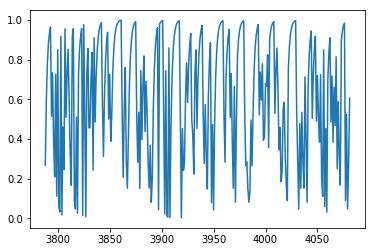

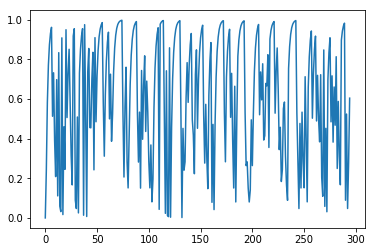

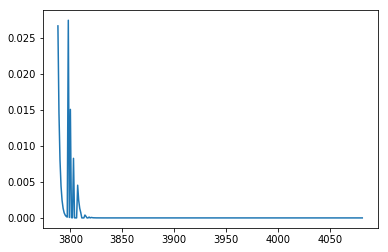

In [44]:
plt.plot(mydf['Q'])
plt.figure(2)
plt.plot(rat.qlog)
plt.figure(3)
plt.plot(mydf['Q']-rat.qlog[1:])

# MLE

In [61]:
mydf

,session,subject,lever,response,feedback,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE
3788,Best,12,A,rich,0.0,1.0,1.0,0.0,0.450942,0.466634,0.553753,0.266683,-0.500000
3789,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.597366,0.733317
3790,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.778931,0.402634
3791,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.878620,0.221069
3792,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.933355,0.121380
3793,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.963408,0.066645
3794,Best,12,A,rich,0.0,1.0,1.0,0.0,0.450942,0.466634,0.553753,0.513849,-0.963408
3795,Best,12,A,rich,1.0,1.0,1.0,1.0,0.450942,0.466634,0.553753,0.733075,0.486151
3796,Best,12,A,lean,0.0,1.0,1.0,0.0,0.450942,0.466634,0.553753,0.390997,-0.733075
3797,Best,12,A,lean,0.0,1.0,1.0,0.0,0.450942,0.466634,0.553753,0.208545,-0.390997


# Visualization

# PE is R-Q

# I/O